# Investments notebook

TO DO LIST:

1. Backtest still does not have short parts 
2. Use a bool to separate long and shirt instead of repeating code
3. Numba compiler and multiprocessing
4. Write readme file for repository
5. Release first version with MACD strategy!
6. Stochastics would be nice in the investments notebook
7. More correlation things like in p. 226 and p. 436 (USE RETURNS NOT PRICE) of book
8. How's machine learning going?
9. Improve documentation
10. vectorized backtesting!

## 0. Make the necessary imports

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from library.stock_lists import *
from library.market_analysis import *
from library.financial_indicators import *
from library.candlestick_patterns import *
from library.strategy_screeners import *
from library.entry_rules import *
from library.diversification import *
from library.backtesting import *
from library.statistics import *
import warnings
warnings.filterwarnings('ignore')

## 1. Filter for relevant stocks

### 1.1 Importing stock lists

If you have already generated the lists of high volume stocks and stocks with strong or weak relative strength in comparison to the S&P500, you can simply run the cell below to import these lists. If not, please follow the steps in sections 1.2 and 1.3 to produce these lists. We recommend re-running Secs. 1.2 and 1.3 at least once per month to keep the lists updated

In [2]:
Stock_lists.import_stock_lists()

### 1.2 High volume stocks

Low volume stocks carry a higher risk of investment. Thus, it is recommended to focus our attention is stocks that are traded daily with a high volume. In this section, we consider only the stocks which have been traded consistently with an average volume of 200000 in the past 30 days. Given that this process is time consuming, these stocks are saved in a list of high volume stocks for later use. We recommend to re-run this block at least once per month to guarantee that the list of high volume stocks is up to date.

In [3]:
Stock_lists.produce_high_volume_list(volume = 200000, export = True)

### 1.3 Relative strength analysis

Relative strength measures how well a stock has performed in comparison with the market indicator, i.e., the S&P500. Long positions for stocks with large relative strengths and short positions for stocks with small relative strengths are less risky than the other way around. Thus, it is recommended that, during an uptrend, one focuses on stocks with large relative strengths, and vice-versa for downtrends. This section filters the high volume stocks and separates them into two lists, one for strong and one for weak stocks, in comparison with the S&P500, in the past 30 days. These lists are saved in a file. It is recommended to run this block at least once per month to guarantee that the lists are updated.

In [3]:
Stock_lists.produce_relative_strength_lists(period = 30, export = True)

## 2. Strategy type selection

### 2.1 Verification of market trend

Use four moving averages with different periods to verify the short-term and long-term trends of the S&P500. This analysis serves to decide wether to go for long or short strategies, when the market is bullish or bearish, respectively. If the market is found to be currently indecisive or trending sideways, it is recommended to stay out of the market. 

### 2.2 Verification of price oscillation

Even if the market is found to be currently uptrending or downtrending, one might prefer to stay out of the market in case the market is currently overbought or oversold, respectively. To verify wether this is the case, we recur to a simple stochastic indicator. Long strategies are recommended if the market is uptrending and not overbought, whereas short strategies are recommended if the market is downtrending and not oversold. Otherwise, it is recommended to stay out of the market until it regresses to the mean.

### 2.3 Decision for market strategies

Taking into consideration the trend of the market and the current price status, we conclude which type of strategy to follow. If the market is currently uptrending and not in an overbought state, long positions are recommended. If the market is currently downtrending and not in an oversold state, short positions are recommended. Otherwise, it is recommended to stay inective until the market retraces.

Market is currently indecisive.


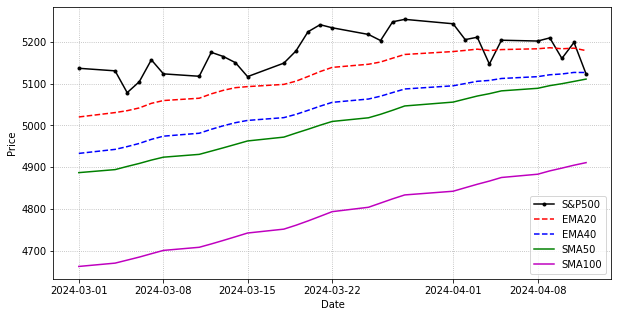

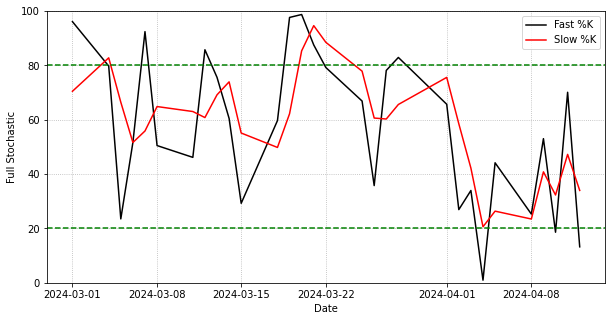

In [4]:
Market_analysis.analyze_market(plot = True)

## 3. Strategy screeners

### 3.1 MACD crossover strategy

The first strategy in this notebook is the MACD crossover strategy. In this strategy, a buy signal is given when the MACD line crosses above the signal line (for the bullish case), and a sell signal is given when the MACD line crosses below the signal line (for the bearish case). The recommended profit ratio for this strategy is around 2 to 2.5 the risk ratio. In the following, we introduce both the long and short versions of this strategy.

#### Long strategy

In [3]:
Screener.screener_MACD_crossover_long(Stock_lists.strong_stocks)
Screener.screened_stocks_list

It is not recommended to follow this strategy in the current market condition.


['ALVR',
 'BREA',
 'COST',
 'HRTX',
 'IGMS',
 'MNPR',
 'SLN',
 'SYRA',
 'URGN',
 'BTAL',
 'FRO']

#### Short strategy

In [6]:
Screener.screener_MACD_crossover_short(Stock_lists.weak_stocks[0:100]) 
Screener.screened_stocks_list

It is not recommended to follow this strategy in the current market condition.


## 4. Order placement

### 4.1 Entry rules

For the stocks for which signals were detected through the screeners above, one can now decide to enter the trade. To minimize the risk of losing the trade or entering the trade at the wrong price, it is recommended to follow a strict set of entry rules. These rules define the price at which one enters the trade, and also the prices at which one takes profit or stops the loss. 

### 4.2 Position sizing

Having decided on the prices at which to place the buy and sell orders, it is now necessary to calculate how many stocks one should buy under those conditions to guarantee that the risk ratio is low and that the profit ratio is larger than the risk ratio. For a fixed value of both the risk and profit ratios, one can compute the number of stocks to buy in agreement with the entry rules.

#### Long strategy

In [7]:
order_details_long_list(Screener.screened_stocks_list, 100000, 2, 1)

Stock:  ALVR

    Buy stop: 0.79
    Buy limit: 0.8
    Sell stop: 0.73
    Sell limit: 0.89

    Number of shares: 18867
    Position size: 14848.33
    Total risk: 1000.0
    
Stock:  BREA

    Buy stop: 1.5
    Buy limit: 1.51
    Sell stop: 1.34
    Sell limit: 1.82

    Number of shares: 6250
    Position size: 9375.0
    Total risk: 1000.0
    
Stock:  ALVR

    Buy stop: 0.79
    Buy limit: 0.8
    Sell stop: 0.73
    Sell limit: 0.89

    Number of shares: 18867
    Position size: 14848.33
    Total risk: 1000.0
    
Stock:  BREA

    Buy stop: 1.5
    Buy limit: 1.51
    Sell stop: 1.34
    Sell limit: 1.82

    Number of shares: 6250
    Position size: 9375.0
    Total risk: 1000.0
    
Stock:  COST

    Buy stop: 733.0
    Buy limit: 733.1
    Sell stop: 724.05
    Sell limit: 750.9

    Number of shares: 111
    Position size: 81363.0
    Total risk: 1000.0
    
Stock:  HRTX

    Buy stop: 3.08
    Buy limit: 3.09
    Sell stop: 2.85
    Sell limit: 3.54

    Number of shar

#### Short strategy

In [ ]:
order_details_short_list(Screener.screened_stocks_list, 100000, 2, 1)

## 5. Diversification

### 5.1 Price correlation

It can happen that two or more of the stocks screened previously are correlated pricewise. If that is the case, and assuming that the correlation extrapolates into the future, having a position in two of the correlated stocks effectively works as having a single position, twice the size, into any of the stocks independently. Thus, to increase the diversification of the portfolio, it is recommended that, if several stocks are strongly correlated, to open a position in a single one of those stocks.

### 5.2 Sector analysis

Even though the stock prices might not be strongly correlated amonst themselves, if two or more stocks belong in the same sector, these stocks are affected simultaneously by variations in the sector itself. Thus, to increase diversification, it is recommended that, if several stocks belong to the same sector, one should open a position in only one of those stocks.

In [4]:
Diversification.complete_diversify()
Diversification.diversified_stocks

['HRTX', 'BREA', 'COST', 'FRO']

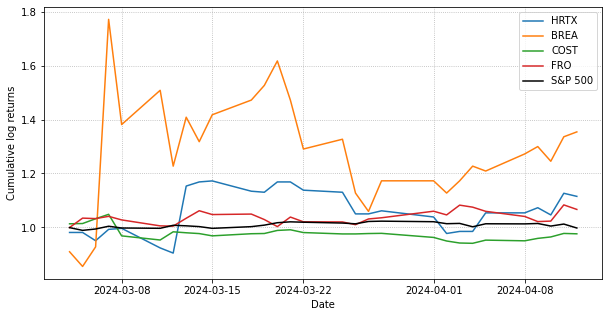

In [7]:
compare_stocks(Diversification.diversified_stocks)

## 6. Backtesting

Backtesting is essential to verify if a given strategy has a positive success rate expectancy. To backtest a strategy, it is necessary to look into the past data of a series of stocks and verify how many trades one would have taken following the strategy being tested, as well as how many of those trades have been successful and unsuccessful. The backtester implemented in this notebook returns the number of trades taken in that strategy, the success rate, and the average profit per trade.

In [9]:
backtest_MACD_crossover(Diversification.diversified_stocks, 100000, 1, 2)


    Backtesting results:

    Number of trades: 9
    Wins: 5
    Losses: 4
    Longest winning streak: 3
    Longest losing streak: 1
    Success_rate: 55.6%
    Average profit per trade: 0.7%

    Initial capital: 100000
    Final capital: 106029.91
    Profit percentage: 6.0%
    


# PORTFOLIO OPTIMIZATION


        Sharpe optimization:
        Optimized weights:    [0.709 0.291 0.   ]
        Optimized returns:    0.278
        Optimized volatility: 0.262
        Optimized Sharpe:     1.061
        

        Risk optimization:
        Optimized weights:    [0.492 0.352 0.155]
        Optimized returns:    0.266
        Optimized volatility: 0.259
        Optimized Sharpe:     1.03
        


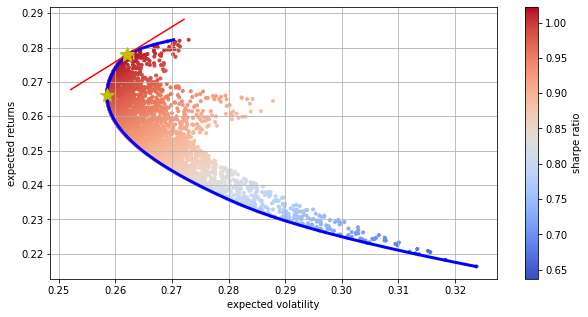

In [3]:
Portfolio(["MSFT", "AAPL", "AMZN"], rf = 0.01).optimize_portfolio()